In [1]:
# First approach to Smart Charging Phase 1 using PuLP.
# Modeled as a PuLP optimisation blending problem
# Started 20 Aug 2020
# Author: Sofia Taylor, Flexible Power Systems
# test new laptop

import numpy as np
import pandas as pd
import datetime as dt
from pulp import *
import pickle
import global_variables as gv
import functions as f
import matplotlib.pyplot as plt

In [48]:
# Import journey and price data

prot_journeys = pickle.load(open('Data/prototype_week','rb'))
test_journeys = pickle.load(open('Data/test_week','rb'))
BAU_profile = pickle.load(open('Data/BAU_profile','rb'))
day_journeys = f.get_daily_data(prot_journeys, gv.DAY)
day_profile = f.create_daily_schedule(BAU_profile, gv.DAY)

In [49]:
# Check if algorithm is working fine

day_journeys.loc[0,'End_Time_of_Route'] = dt.datetime(2019,2,10,17,0,21)
day_journeys.head()

,End_Time_of_Route,Energy_Required,Start_next_route
Vehicle_ID,,,
0,2019-02-10 17:00:21,26.8191,2019-02-11 05:15:00
1,2019-02-10 12:58:59,31.331,2019-02-11 05:15:00
2,2019-02-10 12:35:00,26.5713,2019-02-11 05:15:00
3,2019-02-10 13:14:00,23.5697,2019-02-11 05:15:00
4,2019-02-10 11:05:59,29.2441,2019-02-11 05:15:00


In [50]:
# Define output variable
outputs = LpVariable.dicts("output",
((period, vehicle) for period, vehicle in day_profile.index),
lowBound = 0,
upBound = 3.5,
cat = "Continuous"
)

In [51]:
# Create the 'prob' variable to contain the problem data
prob = LpProblem("Multiple_vehicle_scheduling",LpMinimize)

# Add costs to objective function

prob += lpSum(
    [day_profile.loc[(period, vehicle), 'unit_rate_excl_vat'] * outputs[period, vehicle] for period, vehicle in day_profile.index]
    ), "Total Charging costs"

# Final SOC constraint
time_period = day_profile.index.get_level_values(0)
vehicles = day_journeys.index

for vehicle in vehicles:
    prob += lpSum(
        [outputs[period, vehicle] for period in time_period])/gv.NUM_VEHICLES == day_journeys.loc[vehicle, 'Energy_Required'] / gv.CHARGER_EFF

# Output after/before departure/arrival is 0

for period, vehicle in day_profile.index:
    arrival = day_journeys.loc[vehicle, "End_Time_of_Route"]
    departure = day_journeys.loc[vehicle, "Start_next_route"]
    if period < arrival:
        prob += outputs[(period, vehicle)] == 0
    elif period + dt.timedelta(minutes=30) > departure:
        prob += outputs[period, vehicle] == 0

# Max capacity constraint
for period in time_period:
    prob += lpSum(
        [outputs[period, vehicle] for vehicle in vehicles]) <= gv.SITE_CAPACITY

In [52]:
# Solve and print to the screen
prob.solve()
print("Status:", LpStatus[prob.status])

# Get output variables
charge_output = []

for period, vehicle in outputs:
    var_output = {
        'from': period,
        'Vehicle': vehicle,
        'Output_Opt': outputs[(period, vehicle)].varValue
    }
    charge_output.append(var_output)

output_df = pd.DataFrame.from_records(charge_output).sort_values(['from','Vehicle'])
output_df.set_index(['from', 'Vehicle'], inplace=True)
print('Cost:', value(prob.objective))
day_profile = day_profile.merge(
    output_df,
    how='left',
    left_index=True,
    right_index=True,
    )


Status: Optimal
Cost: 2590.3612090363995


In [57]:
def summary_outputs(profile, journeys):
    day_profile = profile.copy()
    day_profile['Charge_Delivered_Opt'] = day_profile['Output_Opt'] * gv.CHARGER_EFF
    day_profile['Charge_Delivered_BAU'] = day_profile['Output_BAU'] * gv.CHARGER_EFF
    day_profile['Electricity_Cost_Opt'] = day_profile['Output_Opt'] * day_profile['unit_rate_excl_vat']
    day_profile['Electricity_Cost_BAU'] = day_profile['Output_BAU'] * day_profile['unit_rate_excl_vat']
    for vehicle in vehicles:
        opt_soc = (gv.BATTERY_CAPACITY - journeys.loc[vehicle,'Energy_Required'] + day_profile.loc[(slice(None),vehicle),'Charge_Delivered_Opt'].cumsum())*100 / gv.BATTERY_CAPACITY
        day_profile.loc[(slice(None),vehicle),'SOC_Opt'] = opt_soc
        opt_BAU = (gv.BATTERY_CAPACITY - journeys.loc[vehicle,'Energy_Required'] + day_profile.loc[(slice(None),vehicle),'Charge_Delivered_BAU'].cumsum())*100 / gv.BATTERY_CAPACITY
        day_profile.loc[(slice(None),vehicle),'SOC_BAU'] = opt_BAU

    day_journeys = journeys.copy()
    day_journeys['Energy_Use_Opt'] = day_profile['Output_Opt'].groupby(level=1).sum()
    day_journeys['Energy_Use_BAU'] = day_profile['Output_BAU'].groupby(level=1).sum()
    day_journeys['Electricity_Cost_Opt'] = day_profile['Electricity_Cost_Opt'].groupby(level=1).sum()
    day_journeys['Electricity_Cost_BAU'] = day_profile['Electricity_Cost_BAU'].groupby(level=1).sum()
    day_journeys['Peak_Output_Opt'] = day_profile['Output_Opt'].groupby(level=1).max()
    day_journeys['Peak_Output_BAU'] = day_profile['Output_BAU'].groupby(level=1).max()

    site = day_profile.groupby(level=0).sum()
    site['unit_rate_excl_vat'] = site['unit_rate_excl_vat']/gv.NUM_VEHICLES
    site['SOC_Opt'] = site['SOC_Opt']/gv.NUM_VEHICLES
    site['SOC_BAU'] = site['SOC_BAU']/gv.NUM_VEHICLES

    global_summary = site.sum()
    global_summary.drop(labels=['unit_rate_excl_vat','SOC_Opt','SOC_BAU'], inplace=True)
    return day_profile, day_journeys, site, global_summary

In [58]:
day_profile, day_journeys, site_summary, global_summary = summary_outputs(
    day_profile,
    day_journeys
)

global_summary


Output_BAU               291.241793
Output_Opt               291.241793
Charge_Delivered_Opt     262.117613
Charge_Delivered_BAU     262.117613
Electricity_Cost_Opt    2590.361209
Electricity_Cost_BAU    4448.177296
dtype: float64

In [61]:
site_summary.head()

,Output_BAU,unit_rate_excl_vat,Output_Opt,Charge_Delivered_Opt,Charge_Delivered_BAU,Electricity_Cost_Opt,Electricity_Cost_BAU,SOC_Opt,SOC_BAU
from,,,,,,,,,
2019-02-10 11:00:00,0.0,12.26,0.0,0.0,0.00,0.00,0.00,65.050985,65.050985
2019-02-10 11:30:00,3.5,12.02,0.0,0.0,3.15,0.00,42.07,65.050985,65.470985
2019-02-10 12:00:00,3.5,11.60,0.0,0.0,3.15,0.00,40.60,65.050985,65.890985
2019-02-10 12:30:00,3.5,11.36,0.0,0.0,3.15,0.00,39.76,65.050985,66.310985
2019-02-10 13:00:00,14.0,8.96,14.0,12.6,12.60,125.44,125.44,66.730985,67.990985


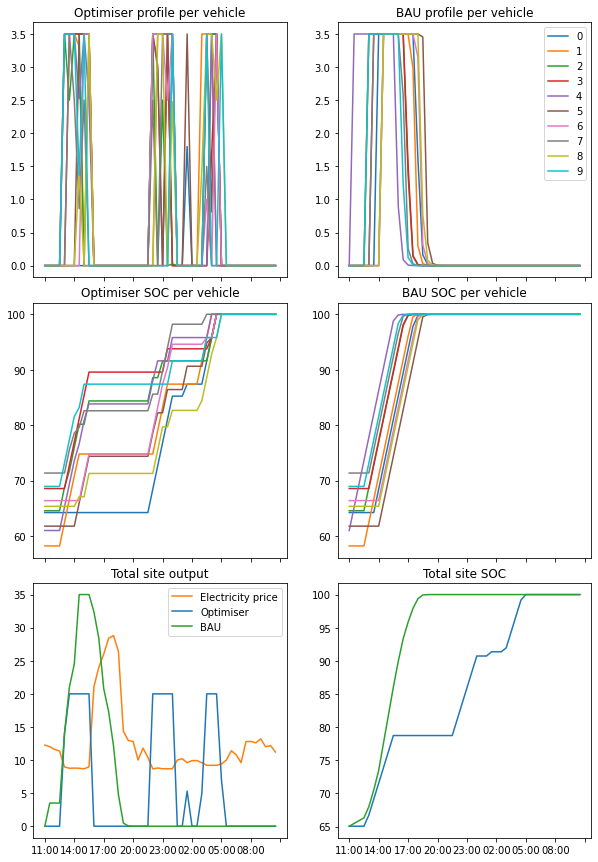

In [63]:
fig, axs = plt.subplots(3,2,figsize=(10,15), sharex=True, gridspec_kw={'hspace':0.1})

x = day_profile.unstack().index.strftime('%H:%M')

axs[0,0].plot(x, day_profile['Output_Opt'].unstack())
axs[0,0].set_title('Optimiser profile per vehicle')

axs[0,1].plot(x, day_profile['Output_BAU'].unstack())
axs[0,1].set_title('BAU profile per vehicle')
axs[0,1].legend(vehicles)

axs[1,0].plot(x, day_profile['SOC_Opt'].unstack())
axs[1,0].set_title('Optimiser SOC per vehicle')

axs[1,1].plot(x, day_profile['SOC_BAU'].unstack())
axs[1,1].set_title('BAU SOC per vehicle')

axs[2,0].plot(x, site_summary['unit_rate_excl_vat'], label = 'Electricity price', color='tab:orange')
axs[2,0].plot(x, site_summary['Output_Opt'], label='Optimiser', color='tab:blue')
axs[2,0].plot(x, day_profile['Output_BAU'].groupby(level=0).sum(), label='BAU', color='tab:green')
axs[2,0].legend()
axs[2,0].set_title('Total site output')

axs[2,1].plot(x, site_summary['SOC_Opt'], label='SOC all vehicles',color='tab:blue')
axs[2,1].plot(x, site_summary['SOC_BAU'], label='SOC all vehicles BAU',color='tab:green')
axs[2,1].set_title('Total site SOC')

for ax in fig.get_axes():
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))


In [85]:
run = 1# For now change this manually
notes = 'Initial log test'
# Create a list of settings
with open('global_variables.py','r') as f:
    global_variables = f.read()
os.makedirs('Outputs/Logs/run{}'.format(run))
with open('Outputs/Logs/run{}/variables{}.csv'.format(run,run),'a') as f:
    f.write(global_summary.to_string())
    f.write('\nglobal_variabes.py:\n')
    f.write(global_variables)
    f.write(notes)

# The problem data is written to an .lp file
prob.writeLP("Outputs/Logs/run{}/multi_vehicle.lp".format(run))

# Save dataframes
day_profile.to_json(r'Outputs/Logs/run{}/profiles{}.json'.format(run,run))
day_journeys.to_json(r'Outputs/Logs/run{}/vehicles{}.json'.format(run,run))
site_summary.to_json(r'Outputs/Logs/run{}/site_summary{}.json'.format(run,run))

# Save figure
fig.savefig('Outputs/Logs/run{}/fig{}.svg'.format(run,run),facecolog='white')
plt.close(fig)